# 1 定义处理函数 import相关包

In [161]:
import sys
import pandas as pd
import numpy as np
from sklearn import metrics

from itertools import chain

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

import matplotlib.pyplot as plt

In [162]:
def cal_sub_class(sub_class):
    if sub_class[0] == 'A':
        return 10 + int(sub_class[1])
    elif sub_class[0] == 'B':
        return 20 + int(sub_class[1])
    elif sub_class[0] == 'C':
        return 30 + int(sub_class[1])
    elif sub_class[0] == 'D':
        return 40 + int(sub_class[1])
    elif sub_class[0] == 'E':
        return 50 + int(sub_class[1])
    elif sub_class[0] == 'F':
        return 60 + int(sub_class[1])
    else:
        return 70 + int(sub_class[1])


def cal_work_year(work_year):
    if work_year == '-1':
        return -1
    elif '<' in work_year:
        return 0
    elif '+' in work_year:
        return 11
    else:
        year = work_year.split(' ')[0]
        return int(year)


def cal_issue_date(issue_date):
    result = (2021 - int(issue_date[:4])) + (12 - int(issue_date[5:7])) / 12
    return float(result)


def cal_earlies_credit_mon(earlies_credit_mon):
    result = 0
    if earlies_credit_mon[:3] == 'Jan':
        result = (2021 - int(earlies_credit_mon[-4:])) + 1
    elif earlies_credit_mon[:3] == 'Feb':
        result = (2021 - int(earlies_credit_mon[-4:])) + 11 / 12
    elif earlies_credit_mon[:3] == 'Mar':
        result = (2021 - int(earlies_credit_mon[-4:])) + 10 / 12
    elif earlies_credit_mon[:3] == 'Apr':
        result = (2021 - int(earlies_credit_mon[-4:])) + 9 / 12
    elif earlies_credit_mon[:3] == 'May':
        result = (2021 - int(earlies_credit_mon[-4:])) + 8 / 12
    elif earlies_credit_mon[:3] == 'Jun':
        result = (2021 - int(earlies_credit_mon[-4:])) + 7 / 12
    elif earlies_credit_mon[:3] == 'Jul':
        result = (2021 - int(earlies_credit_mon[-4:])) + 6 / 12
    elif earlies_credit_mon[:3] == 'Aug':
        result = (2021 - int(earlies_credit_mon[-4:])) + 5 / 12
    elif earlies_credit_mon[:3] == 'Sep':
        result = (2021 - int(earlies_credit_mon[-4:])) + 4 / 12
    elif earlies_credit_mon[:3] == 'Oct':
        result = (2021 - int(earlies_credit_mon[-4:])) + 3 / 12
    elif earlies_credit_mon[:3] == 'Nov':
        result = (2021 - int(earlies_credit_mon[-4:])) + 2 / 12
    else:
        result = (2021 - int(earlies_credit_mon[-4:])) + 1 / 12
    return float(result)

# 2 数据输入

In [163]:
spark = SparkSession.builder.master("local[*]").appName("predict").getOrCreate()

In [164]:
df = spark.read.options(header='True', inferSchema='True', delimiter=',').csv(r'E:\大三上课程\金融大数据\实验\Experiment4\train_data.csv') #读取数据

In [165]:
df.printSchema()

root
 |-- loan_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- total_loan: double (nullable = true)
 |-- year_of_loan: integer (nullable = true)
 |-- interest: double (nullable = true)
 |-- monthly_payment: double (nullable = true)
 |-- class: string (nullable = true)
 |-- sub_class: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- employer_type: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- work_year: string (nullable = true)
 |-- house_exist: integer (nullable = true)
 |-- house_loan_status: integer (nullable = true)
 |-- censor_status: integer (nullable = true)
 |-- marriage: integer (nullable = true)
 |-- offsprings: integer (nullable = true)
 |-- issue_date: string (nullable = true)
 |-- use: integer (nullable = true)
 |-- post_code: double (nullable = true)
 |-- region: integer (nullable = true)
 |-- debt_loan_ratio: double (nullable = true)
 |-- del_in_18month: double (nullable = true)
 |-- scoring_low: dou

# 3 数据预处理
## 3.1 处理缺失值

In [166]:
df = df.na.fill(-1)
df = df.na.fill('-1')

## 3.2 用自定义函数将string类型转数值型特征

In [167]:
udf_cal_work_year = udf(cal_work_year, IntegerType())
udf_cal_sub_class = udf(cal_sub_class, IntegerType())
udf_cal_issue_date = udf(cal_issue_date, FloatType())
udf_cal_earlies_credit_mon = udf(cal_earlies_credit_mon, FloatType())
# 使用
df = df.withColumn('int_work_year', udf_cal_work_year(df.work_year))
df = df.withColumn('int_sub_class', udf_cal_sub_class(df.sub_class))
df = df.withColumn('float_issue_date', udf_cal_issue_date(df.issue_date))
df = df.withColumn('float_earlies_credit_mon', udf_cal_earlies_credit_mon(df.earlies_credit_mon))

In [168]:
df.select('int_work_year','int_sub_class','float_issue_date','float_earlies_credit_mon').show(5)

+-------------+-------------+----------------+------------------------+
|int_work_year|int_sub_class|float_issue_date|float_earlies_credit_mon|
+-------------+-------------+----------------+------------------------+
|           -1|           25|             6.5|               37.833332|
|           11|           33|       11.166667|                    30.0|
|           11|           42|       5.3333335|                   25.25|
|            2|           21|        8.583333|                    21.5|
|            5|           21|       4.6666665|               21.833334|
+-------------+-------------+----------------+------------------------+
only showing top 5 rows



## 3.3 利用stringindexer转换成数值特征

In [169]:
strings = ['work_type', 'employer_type', 'industry']
indexes = [StringIndexer(inputCol=s, outputCol=s + "_index") for s in strings]
pipeline = Pipeline(stages=indexes)
model = pipeline.fit(df)
df = model.transform(df)  # 对strings里面的列进行transform
df = df.drop(*strings)  # 删去strings里面的内容

In [170]:
df.select('work_type_index', 'employer_type_index', 'industry_index').show(5)

+---------------+-------------------+--------------+
|work_type_index|employer_type_index|industry_index|
+---------------+-------------------+--------------+
|            1.0|                0.0|           9.0|
|            0.0|                0.0|          11.0|
|            2.0|                2.0|           5.0|
|            1.0|                0.0|           1.0|
|            0.0|                1.0|           0.0|
+---------------+-------------------+--------------+
only showing top 5 rows



# 4 生成训练集和测试集
## 4.1 去除无关列

In [171]:
for col in ['loan_id', 'user_id', 'class', 'sub_class', 'issue_date', 'earlies_credit_mon', 'work_year']:
    df = df.drop(col)

## 4.2 划分训练集和测试集

In [172]:
df_feas = df.drop('is_default')
assembler = VectorAssembler(inputCols=df_feas.columns, outputCol="features")
data = assembler.transform(df) #许多属性，features，is_default
train_set, test_set = data.randomSplit([0.8, 0.2])

## 4.3 生成数据权重

In [173]:
y_collect = train_set.select("is_default").groupBy("is_default").count().collect()
unique_y = [x["is_default"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) 

{1: 2.503360748131758, 0: 0.6247903056067853}


In [174]:
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
train_set = train_set.withColumn("weight", mapping_expr.getItem(F.col("is_default")))

train_set.select(['features','weight','is_default']).show(5)

+--------------------+------------------+----------+
|            features|            weight|is_default|
+--------------------+------------------+----------+
|[1000.0,3.0,5.32,...|0.6247903056067853|         0|
|[1000.0,3.0,6.99,...|0.6247903056067853|         0|
|[1000.0,3.0,7.21,...|0.6247903056067853|         0|
|[1000.0,3.0,7.35,...|0.6247903056067853|         0|
|[1000.0,3.0,7.35,...|0.6247903056067853|         0|
+--------------------+------------------+----------+
only showing top 5 rows



# 【准备工作】评价指标函数定义

In [175]:
def cal_evaluate(predictions):
    '''
    自己计算相关指标
    '''
    tp = predictions[(predictions.is_default == 1) & (predictions.prediction == 1)].count()
    tn = predictions[(predictions.is_default == 0) & (predictions.prediction == 0)].count()
    fp = predictions[(predictions.is_default == 0) & (predictions.prediction == 1)].count()
    fn = predictions[(predictions.is_default == 1) & (predictions.prediction == 0)].count()
    try:
        p = float(tp)/(tp + fp)
    except:
        p = 0
    try:
        r = float(tp)/(tp + fn)
    except:
        r = 0
    try:
        f1 = 2*p*r/(p+r)
    except:
        f1 = 0
    acc = predictions[predictions.is_default == predictions.prediction].count()/predictions.count()
    auc = BinaryClassificationEvaluator(labelCol='is_default').evaluate(predictions)
    return p,r,f1,acc,auc

# 5 选用随机森林进行分类预测
## 5.1 模型训练与预测

In [176]:
model_rf = RandomForestClassifier(labelCol='is_default', maxDepth=7, maxBins=700, numTrees=50, weightCol='weight').fit(train_set)
predictions_rf = model_rf.transform(test_set)

In [177]:
predictions_rf.select(['is_default','prediction', 'probability']).show(10,False)

+----------+----------+----------------------------------------+
|is_default|prediction|probability                             |
+----------+----------+----------------------------------------+
|1         |0.0       |[0.6167966658853142,0.3832033341146858] |
|0         |0.0       |[0.7571229989542049,0.2428770010457951] |
|1         |1.0       |[0.34249927131852664,0.6575007286814732]|
|0         |1.0       |[0.49908166526659825,0.5009183347334017]|
|0         |0.0       |[0.7666004375831156,0.23339956241688448]|
|0         |0.0       |[0.861818939303072,0.13818106069692804] |
|0         |0.0       |[0.7513639918350212,0.24863600816497883]|
|0         |0.0       |[0.6445826392391486,0.3554173607608515] |
|0         |0.0       |[0.6668882331919371,0.3331117668080628] |
|0         |0.0       |[0.8144055197916006,0.18559448020839941]|
+----------+----------+----------------------------------------+
only showing top 10 rows



## 5.2 打印特征重要性

<BarContainer object of 38 artists>

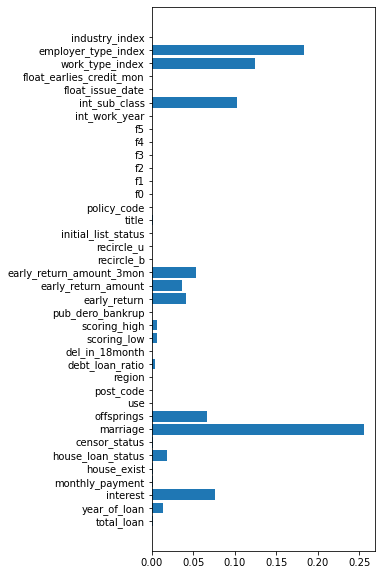

In [178]:
fig = plt.figure(figsize=(4,10))
plt.barh(df_feas.columns, model_rf.featureImportances)

## 5.3 计算指标

In [179]:
p,r,f1,acc,auc = cal_evaluate(predictions_rf)

print("精确率:", p)  # 精确率
print("召回率:", r)  # 召回率
print("F1分数:", f1)  # F1分数
print("准确率:", acc)  
print("auc:", auc)  

精确率: 0.4427646765943964
召回率: 0.8156424581005587
F1分数: 0.5739599835709676
准确率: 0.7585622132074217
auc: 0.8605717064923736


# 6 SVM支持向量机
## 6.1 模型训练与预测

In [180]:
from pyspark.ml.classification import LinearSVC
model_svm = LinearSVC(maxIter=100, labelCol='is_default', weightCol='weight').fit(train_set)
predictions_svm = model_svm.transform(test_set)

In [181]:
predictions_svm.select(['is_default','prediction']).show(10,False)

+----------+----------+
|is_default|prediction|
+----------+----------+
|1         |0.0       |
|0         |0.0       |
|1         |1.0       |
|0         |1.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows



## 6.2 指标计算

In [182]:
p,r,f1,acc,auc = cal_evaluate(predictions_svm)

print("精确率:", p)  # 精确率
print("召回率:", r)  # 召回率
print("F1分数:", f1)  # F1分数
print("准确率:", acc)  
print("auc:", auc) 

精确率: 0.40208270579629074
召回率: 0.7791211540065038
F1分数: 0.530426884650318
准确率: 0.7249451353328457
auc: 0.8178927237891506


# 7 逻辑回归
## 7.1 模型训练与预测

In [183]:
from pyspark.ml.classification import LogisticRegression
model_lr = LogisticRegression(regParam=0.01, labelCol='is_default', weightCol='weight').fit(train_set)
predictions_lr = model_lr.transform(test_set)

In [184]:
predictions_lr.select(['is_default','prediction', 'probability']).show(10,False)

+----------+----------+----------------------------------------+
|is_default|prediction|probability                             |
+----------+----------+----------------------------------------+
|1         |0.0       |[0.8298544021177874,0.1701455978822125] |
|0         |0.0       |[0.8032571712274261,0.19674282877257385]|
|1         |1.0       |[0.26023130518954074,0.7397686948104593]|
|0         |1.0       |[0.4537802912605894,0.5462197087394106] |
|0         |0.0       |[0.7563577993246436,0.24364220067535627]|
|0         |0.0       |[0.7889071150381572,0.21109288496184272]|
|0         |0.0       |[0.6881214888257705,0.3118785111742295] |
|0         |0.0       |[0.6553438995039562,0.3446561004960438] |
|0         |0.0       |[0.6568593770922325,0.3431406229077674] |
|0         |0.0       |[0.8965711222858308,0.1034288777141691] |
+----------+----------+----------------------------------------+
only showing top 10 rows



## 7.2 计算指标

In [185]:
p,r,f1,acc,auc = cal_evaluate(predictions_lr)

print("精确率:", p)  # 精确率
print("召回率:", r)  # 召回率
print("F1分数:", f1)  # F1分数
print("准确率:", acc)  
print("auc:", auc) 

精确率: 0.40543161978661496
召回率: 0.7667806220295172
F1分数: 0.5304109589041096
准确率: 0.7292844317350535
auc: 0.8153035546650128
